In [122]:
import pandas as pd
import numpy as np 
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import re
import string
import itertools

import nltk
import emoji
import unicodedata
import langid
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.corpus import sentiwordnet as swn
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.probability import FreqDist
import langid
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder, TrigramAssocMeasures, TrigramCollocationFinder
from nltk.corpus import wordnet as wn


In [123]:
df = pd.read_csv('GTA_IV.csv')
df.head()

,recommendationid,author,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,hidden_in_steam_china,steam_china_location
0,134424112,"{'steamid': '76561198993940865', 'num_games_ow...",english,Wish someone would do a remastered,1678477261,1678477261,True,0,0,0.000000,0,True,False,False,True,NaN
1,134423512,"{'steamid': '76561199183728970', 'num_games_ow...",english,Great story. As usual rockstar rocked.,1678476540,1678476540,True,0,0,0.000000,0,True,False,False,True,NaN
2,134421968,"{'steamid': '76561198379719399', 'num_games_ow...",english,masterpiece,1678474715,1678474715,True,0,0,0.000000,0,True,False,False,True,NaN
3,134420376,"{'steamid': '76561198859628710', 'num_games_ow...",english,good game 👍🏻 no blacks!,1678472818,1678472818,True,1,0,0.458333,0,True,True,False,True,NaN
4,134416587,"{'steamid': '76561199005901851', 'num_games_ow...",english,Słaba optymalizacja,1678468168,1678468168,False,0,0,0.476190,0,True,False,False,True,NaN


In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41544 entries, 0 to 41543
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   recommendationid             41544 non-null  int64  
 1   author                       41544 non-null  object 
 2   language                     41544 non-null  object 
 3   review                       41426 non-null  object 
 4   timestamp_created            41544 non-null  int64  
 5   timestamp_updated            41544 non-null  int64  
 6   voted_up                     41544 non-null  bool   
 7   votes_up                     41544 non-null  int64  
 8   votes_funny                  41544 non-null  int64  
 9   weighted_vote_score          41544 non-null  float64
 10  comment_count                41544 non-null  int64  
 11  steam_purchase               41544 non-null  bool   
 12  received_for_free            41544 non-null  bool   
 13  written_during_e

In [125]:
def extract_author_data(author_string):
    author_dict = eval(author_string)  # convert the string to a dictionary
    return author_dict

In [126]:
df['author_data'] = df['author'].apply(extract_author_data)

In [127]:
df = pd.concat([df.drop(['author_data'], axis=1), df['author_data'].apply(pd.Series)], axis=1)
df = df.drop(['author'], axis=1)

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41544 entries, 0 to 41543
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   recommendationid             41544 non-null  int64  
 1   language                     41544 non-null  object 
 2   review                       41426 non-null  object 
 3   timestamp_created            41544 non-null  int64  
 4   timestamp_updated            41544 non-null  int64  
 5   voted_up                     41544 non-null  bool   
 6   votes_up                     41544 non-null  int64  
 7   votes_funny                  41544 non-null  int64  
 8   weighted_vote_score          41544 non-null  float64
 9   comment_count                41544 non-null  int64  
 10  steam_purchase               41544 non-null  bool   
 11  received_for_free            41544 non-null  bool   
 12  written_during_early_access  41544 non-null  bool   
 13  hidden_in_steam_

In [129]:
df['voted_up'].value_counts(normalize=True)

True     0.762108
False    0.237892
Name: voted_up, dtype: float64

In [130]:
df['votes_up'].value_counts(normalize=True)

0      0.682337
1      0.186092
2      0.060225
3      0.021977
4      0.010086
         ...   
114    0.000024
280    0.000024
342    0.000024
111    0.000024
231    0.000024
Name: votes_up, Length: 247, dtype: float64

In [131]:
df['votes_funny'].value_counts(normalize=True)

0      0.885110
1      0.075727
2      0.016657
3      0.006186
4      0.003177
         ...   
105    0.000024
56     0.000024
60     0.000024
61     0.000024
42     0.000024
Name: votes_funny, Length: 105, dtype: float64

In [132]:
df['num_games_owned'].describe()

count    41544.000000
mean       171.908675
std        336.869286
min          0.000000
25%         33.000000
50%         83.000000
75%        190.000000
max      13057.000000
Name: num_games_owned, dtype: float64

In [133]:
games_outlier=df.loc[df['num_games_owned']==13057]
for review in games_outlier['review']:
    print(review)

One of my all time favourite games and potentially my favourite GTA (It's difficult to choose as I love them all, including the Stories games on PSP/PS2) of the entire series.

For years I'd wanted to replay this masterpiece on PC as I had played through it to 100% completion many times on the Xbox 360. However, whenever I tried, I suffered the malice of many issues such as GFWL integration and the fact that controllers weren't natively supported within the PC version. However, I can now say these have all been rectified within the Complete Edition, I do of course feel some amount of sorrow when it comes to some players still suffering with issues such as VRAM that plagued the original depot available on Steam, as well as the obvious loss of multiplayer. I myself was never partial to the multiplayer aspect of this game as from what I remember it was a sequence of spawning at the airport and being insta-killed by hackers, similar to that of GTA V but worse.

So while I can't comment too

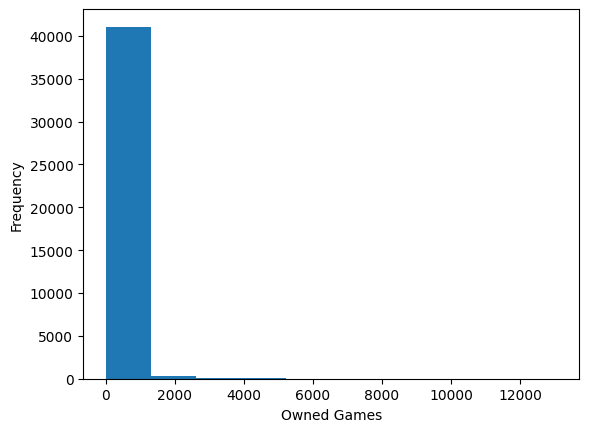

In [134]:
# plot a histogram with 50 bins
plt.hist(df['num_games_owned'])
plt.xlabel('Owned Games')
plt.ylabel('Frequency')
plt.show()

In [135]:
df['num_reviews'].describe()

count    41544.000000
mean        20.104371
std         62.486586
min          1.000000
25%          3.000000
50%          8.000000
75%         20.000000
max       9051.000000
Name: num_reviews, dtype: float64

In [136]:
review_outlier = df.loc[df['num_reviews']==9051]
for review in review_outlier['review']:
    print(review)

There's very little to say about Grand Theft Auto IV that hasn't already been said.  In case you've been living under a rock, it's an epic story of an ex-military Russian who's travelled to Rockstar Studios alternative New York (Liberty City) to hunt down someone who betrayed him in the past.   The expansions, included in this "Complete Edition", tackle the struggles of a biker gang with conflicting leadership, and a pair of nightclub owners embroiled in crime.  The three tales intertwine around a diamond heist in a masterpiece effort of interactive storytelling.

Gameplay consists of a variety of missions wrapped in an expansive, immersive open world city, full of living and breathing NPCs, as well as a momentous number of sideshow activities such as bowling, comedy clubs (with shows by real celebrity comedians such as Ricky Gervais), pool, restaurants, strip clubs, street races, hours of television and radio programming, stunt jumps... the list is practically endless.

This is withou

In [137]:
#Define function to convert a Unix timestamp to a datetime object
def unix_to_datetime(timestamp):
    return datetime.datetime.fromtimestamp(timestamp)
df["last_played"] = df["last_played"].apply(unix_to_datetime)



In [138]:
df['comment_count'].value_counts(normalize=True) # Wont be needing this due to huge imbalance


0     0.938716
1     0.032929
2     0.012035
3     0.004935
4     0.003177
5     0.002215
6     0.001228
7     0.000939
8     0.000554
9     0.000554
11    0.000385
12    0.000337
10    0.000241
14    0.000217
19    0.000193
13    0.000144
15    0.000144
17    0.000144
21    0.000120
16    0.000096
32    0.000096
22    0.000096
24    0.000048
31    0.000048
33    0.000048
57    0.000048
50    0.000048
27    0.000048
52    0.000024
26    0.000024
41    0.000024
23    0.000024
29    0.000024
18    0.000024
20    0.000024
76    0.000024
72    0.000024
Name: comment_count, dtype: float64

In [139]:
df.drop('comment_count', axis= 1, inplace = True)

In [140]:
df['playtime_forever'].value_counts(normalize=True)

6        0.001444
16       0.001420
14       0.001396
27       0.001348
12       0.001324
           ...   
9301     0.000024
11097    0.000024
17468    0.000024
13408    0.000024
8747     0.000024
Name: playtime_forever, Length: 11066, dtype: float64

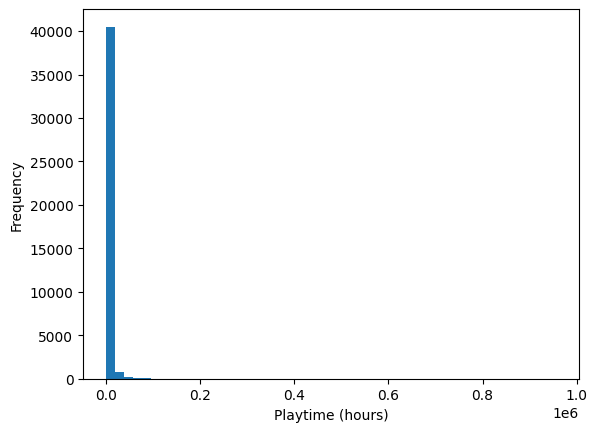

In [141]:
# plot a histogram with 50 bins
plt.hist(df['playtime_forever'], bins=50)
plt.xlabel('Playtime (hours)')
plt.ylabel('Frequency')
plt.show()

In [142]:
playtime_mean = df['playtime_forever'].mean()
df_filtered = df[df['playtime_forever'] >= playtime_mean]
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11296 entries, 10 to 41543
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   recommendationid             11296 non-null  int64         
 1   language                     11296 non-null  object        
 2   review                       11260 non-null  object        
 3   timestamp_created            11296 non-null  int64         
 4   timestamp_updated            11296 non-null  int64         
 5   voted_up                     11296 non-null  bool          
 6   votes_up                     11296 non-null  int64         
 7   votes_funny                  11296 non-null  int64         
 8   weighted_vote_score          11296 non-null  float64       
 9   steam_purchase               11296 non-null  bool          
 10  received_for_free            11296 non-null  bool          
 11  written_during_early_access  11296 non-n

In [145]:
df_filtered.drop(['language','votes_funny','steam_china_location','weighted_vote_score','steam_purchase','received_for_free','written_during_early_access','steamid','hidden_in_steam_china','num_reviews','num_games_owned','playtime_last_two_weeks','playtime_at_review'], axis=1, inplace=True)

/var/folders/18/920vt1r90t39q35zb6glj_6h0000gn/T/ipykernel_13888/8438476.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.drop(['language','votes_funny','steam_china_location','weighted_vote_score','steam_purchase','received_for_free','written_during_early_access','steamid','hidden_in_steam_china','num_reviews','num_games_owned','playtime_last_two_weeks','playtime_at_review'], axis=1, inplace=True)


In [146]:
df_filtered

,recommendationid,review,timestamp_created,timestamp_updated,voted_up,votes_up,playtime_forever,last_played
10,134405286,---{ Graphics }---\n☐ You forget what reality ...,1678456729,1678456729,True,1,4279,2021-12-15 12:40:51
23,134363939,JimmyP u fu3k1ng piece of shit,1678387130,1678387130,True,1,7163,2023-03-09 12:46:45
24,134362798,fun,1678385861,1678385861,True,0,18227,2023-03-09 17:49:46
36,134328365,best gta ever made by far imo,1678329299,1678329299,True,0,32511,2023-03-08 22:43:52
38,134320264,"Best GTA game in the franchise, hands down",1678315125,1678315125,True,0,6438,2023-03-09 21:24:55
...,...,...,...,...,...,...,...,...
41537,207421,best game i've played in a while beside Mass E...,1290242639,1290242639,True,0,5472,2014-08-27 12:09:30
41538,879049,totaly rocks if your computer can take it and ...,1290242115,1290242115,True,0,4215,2012-12-13 03:00:00
41539,1888057,"This game has guns, babes, babes shooting guns...",1290232401,1290232401,True,3,8747,2020-02-11 18:01:06
41540,562928,Very compelling story. Controls can be a bit ...,1290227254,1290227254,True,0,10602,1970-01-01 19:00:00


## Preprocessing

In [147]:
def preprocess_text(text):
    # Lowercase text
    text = text.lower()
    
    # Remove characters
    text = re.sub('[⠎⣰⣿()\'"\[\]]+', '', text)
    
    # Convert emojis to text
    text = emoji.demojize(text)
    
    # Remove numbers and punctuation
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove non-printable characters
    text = "".join(ch for ch in text if unicodedata.category(ch)[0]!="C")
    
    # Tokenize text
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Remove repetitive words
    tokens = list(set(tokens))
    
    # Substitute multiple spaces with single space
    text = re.sub('\s+', ' ', ' '.join(tokens))
    
    # Remove all single characters in the text
    text = re.sub(r'\b\w\b', '', text)
    
    # Lemmatize text
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return tokens


In [148]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11296 entries, 10 to 41543
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   recommendationid   11296 non-null  int64         
 1   review             11260 non-null  object        
 2   timestamp_created  11296 non-null  int64         
 3   timestamp_updated  11296 non-null  int64         
 4   voted_up           11296 non-null  bool          
 5   votes_up           11296 non-null  int64         
 6   playtime_forever   11296 non-null  int64         
 7   last_played        11296 non-null  datetime64[ns]
dtypes: bool(1), datetime64[ns](1), int64(5), object(1)
memory usage: 717.0+ KB


In [149]:
df_filtered['review'] = df_filtered['review'].fillna('')

/var/folders/18/920vt1r90t39q35zb6glj_6h0000gn/T/ipykernel_13888/388833788.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['review'] = df_filtered['review'].fillna('')


In [150]:
df_filtered['preprocessed_text'] = df_filtered['review'].apply(preprocess_text)

/var/folders/18/920vt1r90t39q35zb6glj_6h0000gn/T/ipykernel_13888/2943602941.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['preprocessed_text'] = df_filtered['review'].apply(preprocess_text)


In [151]:
df_filtered = df_filtered.reset_index(drop=True)

In [152]:
num_empty = df_filtered['preprocessed_text'].apply(lambda x: len(x) == 0).sum()
empty_rows = df_filtered[df_filtered['preprocessed_text'].apply(lambda x: len(x)) == 0].index

print(f"There are {num_empty} empty rows.")

There are 224 empty rows.


In [153]:
df_filtered.loc[df_filtered['preprocessed_text'].apply(lambda x: len(x)==0)]

,recommendationid,review,timestamp_created,timestamp_updated,voted_up,votes_up,playtime_forever,last_played,preprocessed_text
7,134255283,.,1678215279,1678215279,True,1,7082,2023-03-09 18:26:07,[]
24,133811413,--,1677604337,1677604337,True,0,6219,2023-02-28 11:02:20,[]
45,133195160,..\n,1676837566,1676837566,True,0,7037,2023-03-07 17:16:39,[]
48,133123667,,1676749760,1676749760,True,0,4213,2023-03-05 21:20:07,[]
57,132889871,10/10,1676460144,1676460144,True,0,4608,2023-02-17 05:51:44,[]
...,...,...,...,...,...,...,...,...,...
11032,3932901,100%,1342824269,1342824269,True,0,5001,2021-04-23 16:41:17,[]
11077,276373,+1,1340598974,1340598974,True,0,5791,2012-07-18 03:00:00,[]
11154,5320003,10/10,1324639740,1324639740,True,0,8598,2021-06-12 03:14:22,[]
11187,3549044,\n,1314506846,1314506846,True,0,4606,2014-11-23 10:32:49,[]


In [154]:
df_filtered= df_filtered.drop(empty_rows)

In [155]:
df_filtered.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 11072 entries, 0 to 11295
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   recommendationid   11072 non-null  int64         
 1   review             11072 non-null  object        
 2   timestamp_created  11072 non-null  int64         
 3   timestamp_updated  11072 non-null  int64         
 4   voted_up           11072 non-null  bool          
 5   votes_up           11072 non-null  int64         
 6   playtime_forever   11072 non-null  int64         
 7   last_played        11072 non-null  datetime64[ns]
 8   preprocessed_text  11072 non-null  object        
dtypes: bool(1), datetime64[ns](1), int64(5), object(2)
memory usage: 789.3+ KB


In [156]:
df_filtered['preprocessed_text']

0        [grinding, paint, lore☐, watch, gameplay, grin...
1                          [fukng, shit, u, jimmyp, piece]
2                                                    [fun]
3                        [ever, best, imo, far, gta, made]
4                       [franchise, hand, best, game, gta]
                               ...                        
11291      [best, played, mass, effect, beside, game, ive]
11292    [take, computer, controler, xd, xbox, pc, tota...
11293    [thing, boom, shooting, go, game, babe, ask, gun]
11294    [time, wont, story, bit, around, find, expansi...
11295    [previous, entry, series, compared, level, def...
Name: preprocessed_text, Length: 11072, dtype: object

### Word frequency & wordcloud 


In [157]:
freq_dist = FreqDist(df_filtered["preprocessed_text"].explode())
fdist = {k[0]:v for k, v in freq_dist.items()}

# Get the top 20 most frequent words from the frequency distribution
top_words = freq_dist.most_common(20)

In [158]:
top_words

[('game', 6693),
 ('gta', 2768),
 ('good', 1976),
 ('story', 1738),
 ('best', 1477),
 ('play', 1408),
 ('great', 1332),
 ('like', 1222),
 ('get', 1150),
 ('one', 1148),
 ('time', 1106),
 ('fun', 1103),
 ('still', 1041),
 ('rockstar', 1024),
 ('even', 909),
 ('better', 881),
 ('go', 863),
 ('pc', 851),
 ('iv', 801),
 ('really', 758)]

In [159]:
words = [word[0] for word in top_words]
frequencies = [word[1] for word in top_words]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

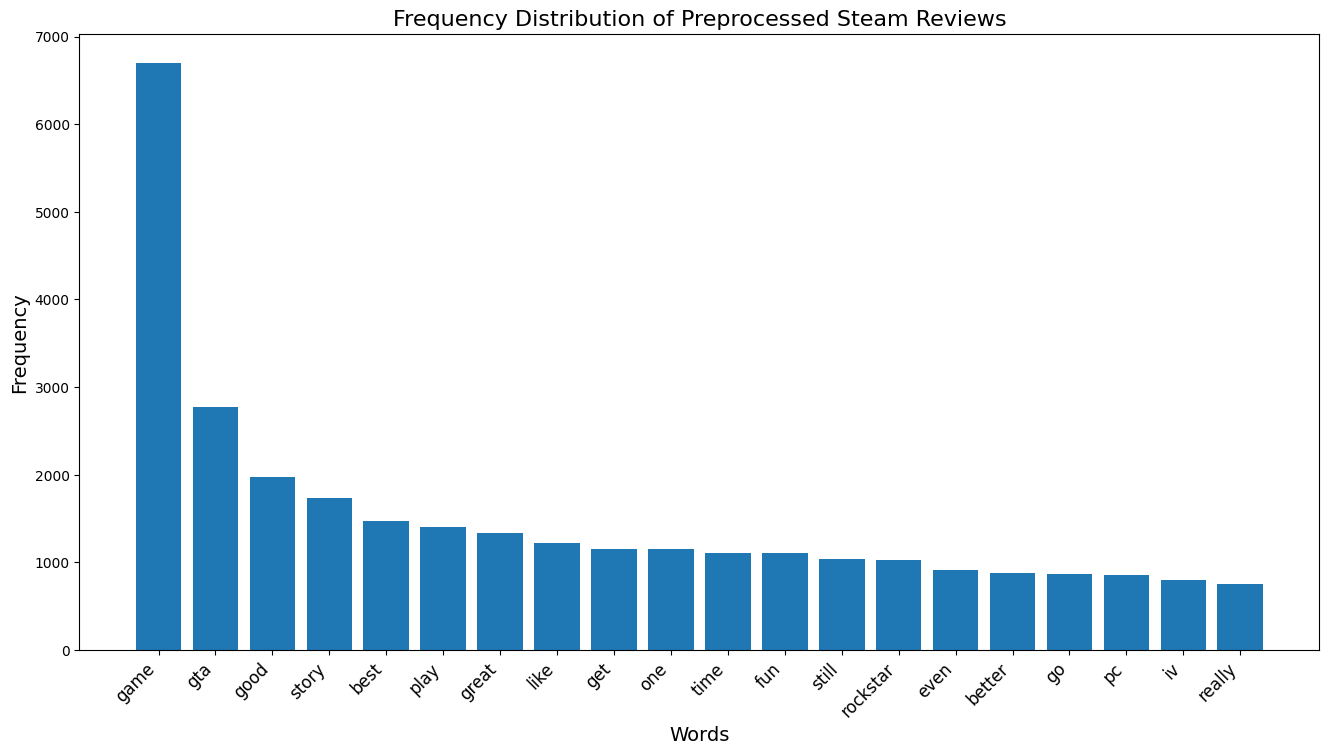

In [160]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.bar(words, frequencies)
ax.set_title("Frequency Distribution of Preprocessed Steam Reviews", fontsize=16)
ax.set_xlabel("Words", fontsize=14)
ax.set_ylabel("Frequency", fontsize=14)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", fontsize=12)


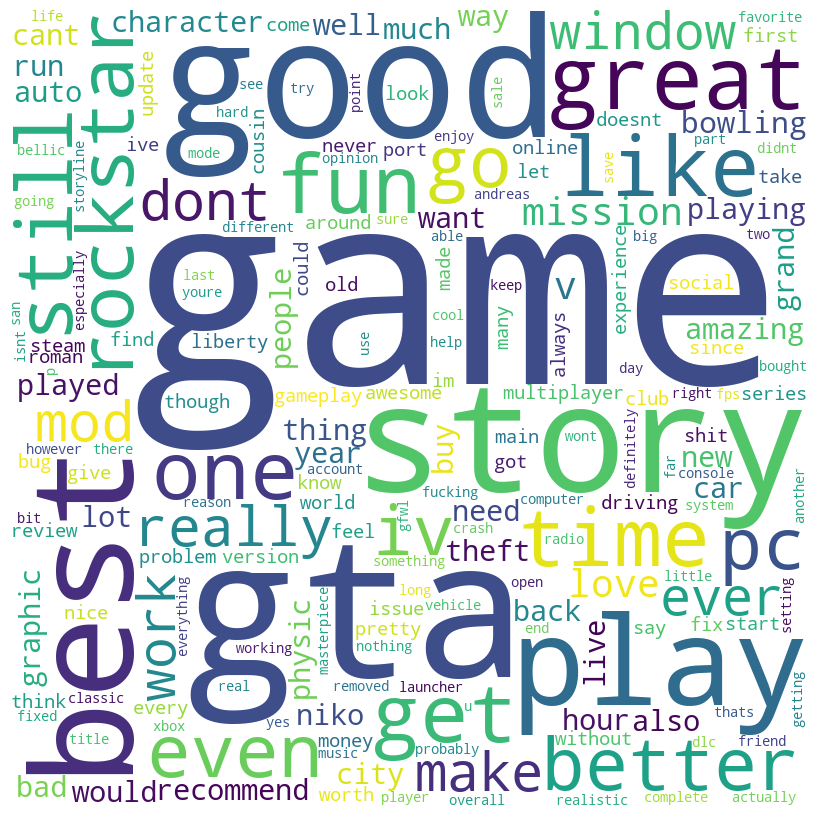

In [161]:
# WordCloud
fdist = {k: v for k, v in freq_dist.items()}
wordcloud = WordCloud(width=800, height=800, background_color='white').generate_from_frequencies(fdist)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

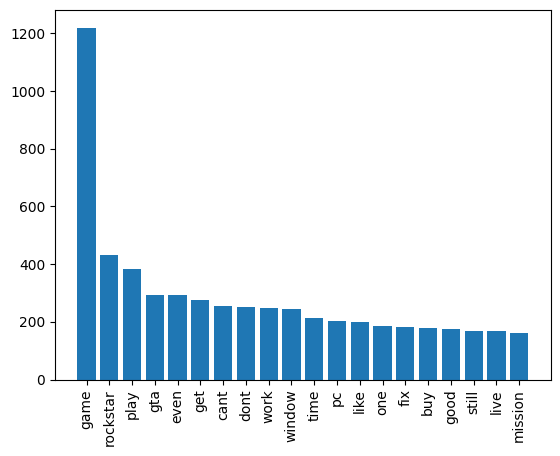

In [162]:
#Voted down users
voted_down= df_filtered[df_filtered['voted_up']==False]
voted_down_freq = FreqDist(voted_down['preprocessed_text'].explode())
top_voted_down = voted_down_freq.most_common(20)
words_3, freqs_2 = zip(*top_voted_down)
words = [w for w in words_3]
plt.bar(words, freqs_2)
plt.xticks(rotation=90)
plt.show()

In [165]:
bigram_measures = BigramAssocMeasures()
tokens = [token for sublist in df_filtered['preprocessed_text'] for token in sublist]
finder = BigramCollocationFinder.from_words(tokens)


In [167]:
finder.apply_freq_filter(3)
scored = finder.score_ngrams(bigram_measures.raw_freq)
for bigram in scored[:10]:
    print(bigram)

(('gta', 'still'), 0.0015814577888067366)
(('game', 'gta'), 0.0013729697844945946)
(('game', 'good'), 0.0013373742715632531)
(('time', 'game'), 0.0013322891982873472)
(('better', 'v'), 0.0010170146551811811)
(('still', 'good'), 0.0009458236293184985)
(('gta', 'good'), 0.0008949728965594394)
(('bowling', 'go'), 0.0008695475301799099)
(('game', 'work'), 0.000864462456904004)
(('best', 'one'), 0.0008542923103521922)
